## Unsupervised Learning
### Segmentasi User --> Algoritma K - Prototypes --> K - Prototypes = K - Means + K - Modes

### Mempersiapkan Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

import pickle
from pathlib import Path

## Membaca Data Pelanggan

In [2]:
df = pd.read_csv("https://storage.googleapis.com/dqlab-dataset/customer_segments.txt", sep="\t")

display(df.head())

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206


## Melihat Informasi Dari Data

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer_ID          50 non-null     object
 1   Nama Pelanggan       50 non-null     object
 2   Jenis Kelamin        50 non-null     object
 3   Umur                 50 non-null     int64 
 4   Profesi              50 non-null     object
 5   Tipe Residen         50 non-null     object
 6   NilaiBelanjaSetahun  50 non-null     int64 
dtypes: int64(2), object(5)
memory usage: 2.9+ KB


None

## Eksplorasi Dataset

### Eksplorasi Data Numerik

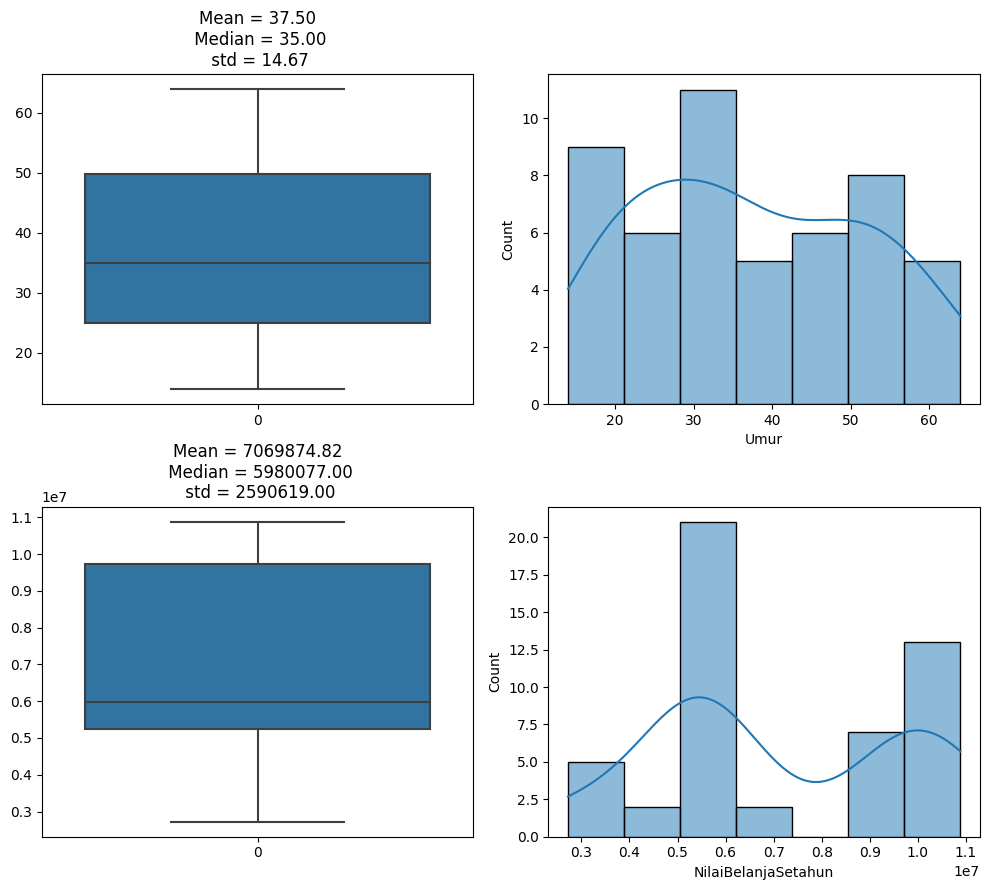

In [4]:
# Fungsi untuk membuat Plot
def obeservasi_num(features):
    fig, axs = plt.subplots(2, 2, figsize=(10, 9))
    for i, col in enumerate(features):
        sns.boxplot(data = df[col], ax = axs[i][0])
        sns.histplot(data = df[col], kde=True, ax = axs[i][1])
        axs[i][0].set_title("Mean = %.2f\n Median = %.2f\n std = %.2f"%(df[col].mean(), df[col].median(), df[col].std()))
    plt.tight_layout()
    plt.show()

# Memanggil Fungsi
numerical_columns = df.select_dtypes(include=["number"]).columns.to_list()
obeservasi_num(numerical_columns)

### Eksplorasi Data Kategorikal

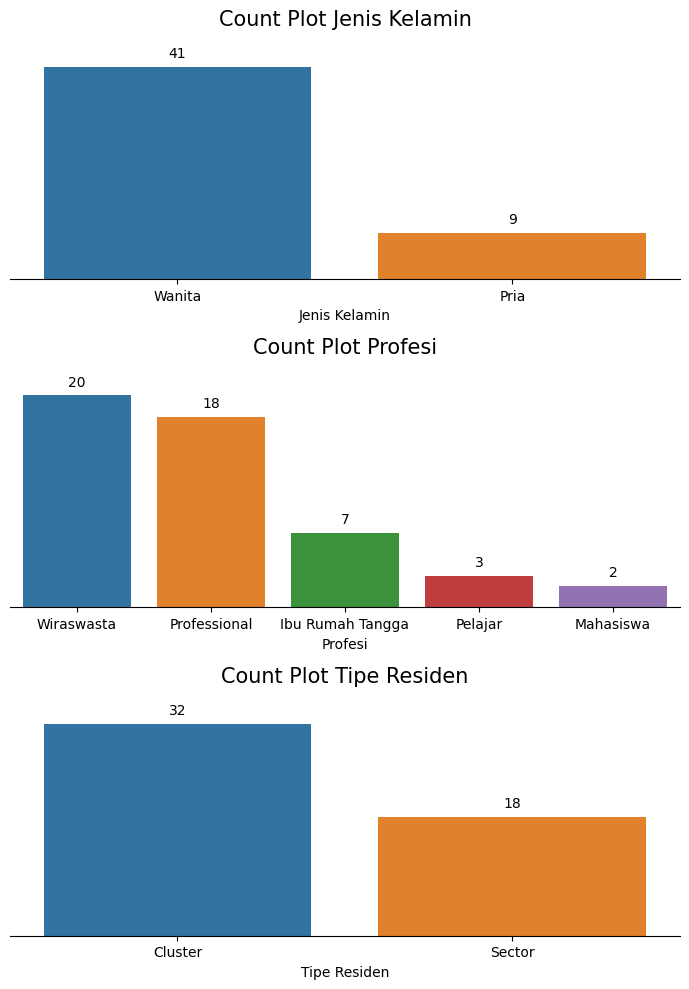

In [5]:
# Menyiapkan Kolom Kategorikal
categorical_columns = df.select_dtypes(exclude=["number"]).columns.to_list()
categorical_columns = [element for element in categorical_columns if element not in ['Customer_ID', 'Nama Pelanggan']]

# Membuat Canvas
fig, axs = plt.subplots(3, 1, figsize=(7, 10))

# Membuat Plot Untuk Setiap Categorical Column
for i, col in enumerate(categorical_columns):
    # Membuat Plot
    sns.countplot(data = df,x=col, order = df[col].value_counts().index, ax = axs[i])
    axs[i].set_title("Count Plot %s\n"%(col), fontsize=15)
    # Memberikan Anotasi
    for p in axs[i].patches:
        axs[i].annotate(
            format(p.get_height(), ".0f"),
            xy = (p.get_x() + p.get_width()/2, p.get_height()),
            ha="center",
            va="center",
            xytext = (0, 10),
            textcoords = "offset points"
        )
    # Setting Plot
    sns.despine(right=True, top=True, left=True)
    axs[i].axes.yaxis.set_visible(False)
    plt.tight_layout()

# Tampilkan Plot
plt.show()

In [6]:
for col in categorical_columns:
    df_categorical_columns = df[[col]].value_counts() / df[[col]].value_counts().sum()
    display(df_categorical_columns)

Jenis Kelamin
Wanita           0.82
Pria             0.18
dtype: float64

Profesi         
Wiraswasta          0.40
Professional        0.36
Ibu Rumah Tangga    0.14
Pelajar             0.06
Mahasiswa           0.04
dtype: float64

Tipe Residen
Cluster         0.64
Sector          0.36
dtype: float64

Kesimpulan

1. Rata - rata dari umur pelanggan adalah 37.5 tahun
2. Rata - rata dari nilai belanja setahun pelanggan adalah Rp. 7.069.874
3. Jenis kelamin di dominasi oleh wanita sebanyak 41 orang dan laki - laki sebanyak 9 orang
4. Profesi terbanyak adalah Wiraswasta (40%) diikuti dengan Professional (36%) dan laiinya (24%)
5. Berdasarkan Tipe Residen pelanggan di dominasi oleh pelanggan yang tinggal di Cluster (64%) dan (36%) tinggal di Sector

## Mempersiapkan Data Sebelum Pemodelan

### Standarisasi Numerical Column

In [7]:
# Statistik Sebelum Standarisasi
print("Statistik sebelum Standarisasi\n")
print(df[numerical_columns].describe().round(1))

# Standarisasi
df_std = StandardScaler().fit_transform(df[numerical_columns])

# Membuat DataFrame
df_std = pd.DataFrame(data=df_std, index=df.index, columns=df[numerical_columns].columns)

# Menampilkan contoh isi data dan summary statistic
print("Contoh hasil standarisasi\n")
print(df_std.head(2))
print("Statistik hasil standarisasi\n")
print(df_std.describe().round(1))

Statistik sebelum Standarisasi

       Umur  NilaiBelanjaSetahun
count  50.0                 50.0
mean   37.5            7069874.8
std    14.7            2590619.0
min    14.0            2722700.0
25%    25.0            5257529.8
50%    35.0            5980077.0
75%    49.8            9739615.0
max    64.0           10884508.0
Contoh hasil standarisasi

       Umur  NilaiBelanjaSetahun
0  1.411245             0.946763
1 -1.617768            -1.695081
Statistik hasil standarisasi

       Umur  NilaiBelanjaSetahun
count  50.0                 50.0
mean   -0.0                 -0.0
std     1.0                  1.0
min    -1.6                 -1.7
25%    -0.9                 -0.7
50%    -0.2                 -0.4
75%     0.8                  1.0
max     1.8                  1.5


### Konversi Categorical Data dengan Label Encoder

In [8]:
# Membuat Salinan Data Frame
df_encode = df[categorical_columns].copy()

# Melakukan Label Encoder untuk Semua Categorical Column
for col in categorical_columns:
    df_encode[col] = LabelEncoder().fit_transform(df_encode[col])

# Menampilkan Data
display(df_encode.head(10))

,Jenis Kelamin,Profesi,Tipe Residen
0,0,4,1
1,1,2,0
2,0,3,0
3,0,3,0
4,1,4,0
5,1,3,0
6,0,4,1
7,0,3,0
8,1,3,1
9,0,3,0


### Menggabungkan Data Untuk Pemodelan

In [9]:
# Menggabungkan Data Untuk Pemodelan
df_model = df_encode.merge(df_std, left_index=True, right_index=True, how="left")
display(df_model.head(10))

,Jenis Kelamin,Profesi,Tipe Residen,Umur,NilaiBelanjaSetahun
0,0,4,1,1.411245,0.946763
1,1,2,0,-1.617768,-1.695081
2,0,3,0,0.722833,-0.695414
3,0,3,0,1.067039,-0.727361
4,1,4,0,0.240944,1.382421
5,1,3,0,-0.929356,-0.723055
6,0,4,1,1.824292,1.079078
7,0,3,0,0.998198,-0.719925
8,1,3,1,-0.585150,-0.419818
9,0,3,0,-0.309785,-0.706714


## Algoritma K - Prototypes

### K-Prototypes = K-Means (Data Numeric) + K-Modes (Data Categorical)

### Mencari Jumlah Cluster yang Optimal

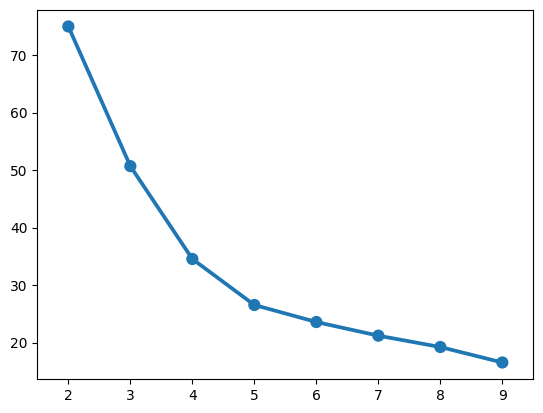

In [10]:
# Melakukan Iterasi untuk Mendapatkan nilai Cost
cost = {}
for k in range(2, 10):
    kproto = KPrototypes(n_clusters=k, random_state=0)
    kproto.fit_predict(df_model, categorical = [0, 1, 2])
    cost[k] = kproto.cost_

# Memvisualisasikan Elbow Plot
sns.pointplot(x=list(cost.keys()), y=list(cost.values()))
plt.show()

### Membuat Model

In [11]:
model_kproto = KPrototypes(n_clusters=5, random_state=0)
model_kproto = model_kproto.fit(df_model, categorical=[0, 1, 2])

# Save Model
pickle.dump(model_kproto, open("model_kproto.pkl", "wb"))

### Tips

In [12]:
cluster_predict = model_kproto.fit_predict(df_model, categorical=[0, 1, 2])

# Calculate Silhoute Score
silhouette_score_avg = silhouette_score(df_model, cluster_predict)
print(silhouette_score_avg)

# Calculate Calinski Harabazs Score
calinski_harabasz_score_avg = calinski_harabasz_score(df_model, cluster_predict)
print(calinski_harabasz_score_avg)

0.31903942040556127
21.140145178222898


### Menggunakan Model

In [13]:
# Menentukan Segmen Tiap Pelanggan
y_predict_cluster = model_kproto.predict(df_model, categorical=[0, 1, 2])
display(y_predict_cluster)

# Menggabungkan Data Awal dan Segmen Pelanggan
df_final = df.copy()
df_final["cluster"] = y_predict_cluster
display(df_final.head(10))

array([2, 1, 3, 3, 0, 4, 2, 3, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3, 0, 1, 0, 3,
       4, 0, 0, 3, 0, 4, 3, 3, 1, 2, 1, 0, 4, 0, 4, 2, 4, 1, 4, 0, 4, 0,
       4, 0, 3, 2, 4, 2], dtype=uint16)

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927,2
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700,1
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429,3
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498,3
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206,0
5,CUST-006,Rosalina Kurnia,Wanita,24,Professional,Cluster,5215541,4
6,CUST-007,"Cahyono, Agus",Pria,64,Wiraswasta,Sector,9837260,2
7,CUST-008,Danang Santosa,Pria,52,Professional,Cluster,5223569,3
8,CUST-009,Elisabeth Suryadinata,Wanita,29,Professional,Sector,5993218,4
9,CUST-010,Mario Setiawan,Pria,33,Professional,Cluster,5257448,4


### Menampilkan Cluster Tiap Pelanggan

In [14]:
# Menampilkan Data Pelanggan Berdasarkan Cluster
length_cluster = len(df_final["cluster"].unique().tolist())
for i in range(0, length_cluster):
    display(df_final[df_final["cluster"] == i])

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206,0
14,CUST-015,Shirley Ratuwati,Wanita,20,Wiraswasta,Cluster,10365668,0
18,CUST-019,Mega Pranoto,Wanita,32,Wiraswasta,Cluster,10884508,0
20,CUST-021,Lestari Fabianto,Wanita,38,Wiraswasta,Cluster,9222070,0
23,CUST-024,Putri Ginting,Wanita,39,Wiraswasta,Cluster,10259572,0
24,CUST-025,Julia Setiawan,Wanita,29,Wiraswasta,Sector,10721998,0
26,CUST-027,Grace Mulyati,Wanita,35,Wiraswasta,Cluster,9114159,0
33,CUST-034,Deasy Arisandi,Wanita,21,Wiraswasta,Sector,9759822,0
35,CUST-036,Ni Made Suasti,Wanita,30,Wiraswasta,Cluster,9678994,0
41,CUST-042,Yuliana Wati,Wanita,26,Wiraswasta,Cluster,9880607,0


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700,1
19,CUST-020,Irene Novianto,Wanita,16,Pelajar,Sector,2896845,1
30,CUST-031,Eviana Handry,Wanita,19,Mahasiswa,Cluster,3042773,1
32,CUST-033,Cecilia Kusnadi,Wanita,19,Mahasiswa,Cluster,3047926,1
39,CUST-040,Irene Darmawan,Wanita,14,Pelajar,Sector,2861855,1


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927,2
6,CUST-007,"Cahyono, Agus",Pria,64,Wiraswasta,Sector,9837260,2
12,CUST-013,Cahaya Putri,Wanita,64,Wiraswasta,Cluster,9333168,2
13,CUST-014,Mario Setiawan,Pria,60,Wiraswasta,Cluster,9471615,2
31,CUST-032,Chintya Winarni,Wanita,47,Wiraswasta,Sector,10663179,2
37,CUST-038,Agatha Salim,Wanita,46,Wiraswasta,Sector,10477127,2
47,CUST-048,Maria Hutagalung,Wanita,45,Wiraswasta,Sector,10390732,2
49,CUST-050,Lianna Nugraha,Wanita,55,Wiraswasta,Sector,10569316,2


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429,3
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498,3
7,CUST-008,Danang Santosa,Pria,52,Professional,Cluster,5223569,3
10,CUST-011,Maria Suryawan,Wanita,50,Professional,Sector,5987367,3
11,CUST-012,Erliana Widjaja,Wanita,49,Professional,Sector,5941914,3
17,CUST-018,Nelly Halim,Wanita,63,Ibu Rumah Tangga,Cluster,5340690,3
21,CUST-022,Novita Purba,Wanita,52,Professional,Cluster,5298157,3
25,CUST-026,Christine Winarto,Wanita,55,Professional,Cluster,5269392,3
28,CUST-029,Tia Hartanti,Wanita,56,Professional,Cluster,5271845,3
29,CUST-030,Rosita Saragih,Wanita,46,Ibu Rumah Tangga,Sector,5020976,3


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster
5,CUST-006,Rosalina Kurnia,Wanita,24,Professional,Cluster,5215541,4
8,CUST-009,Elisabeth Suryadinata,Wanita,29,Professional,Sector,5993218,4
9,CUST-010,Mario Setiawan,Pria,33,Professional,Cluster,5257448,4
15,CUST-016,Bambang Rudi,Pria,35,Professional,Cluster,5262521,4
16,CUST-017,Yuni Sari,Wanita,32,Ibu Rumah Tangga,Cluster,5677762,4
22,CUST-023,Denny Amiruddin,Pria,34,Professional,Cluster,5239290,4
27,CUST-028,Adeline Huang,Wanita,40,Ibu Rumah Tangga,Cluster,6631680,4
34,CUST-035,Ida Ayu,Wanita,39,Professional,Sector,5962575,4
36,CUST-037,Felicia Tandiono,Wanita,25,Professional,Sector,5972787,4
38,CUST-039,Gina Hidayat,Wanita,20,Professional,Cluster,5257775,4


### Visualisasi Hasil Clustering - Box Plot

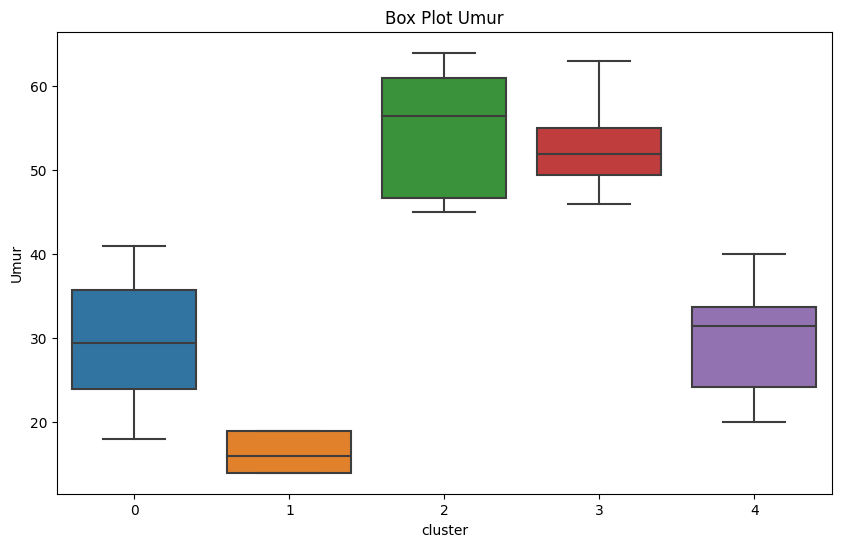

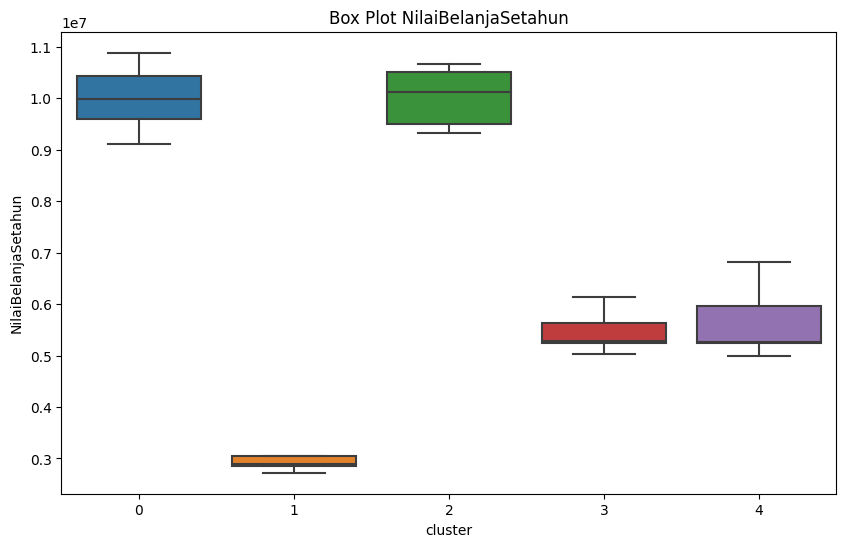

In [15]:
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(data=df_final, x="cluster", y=col)
    plt.title("Box Plot %s"%col, fontsize=12)
    plt.show()

### Visualisasi Hasil Clustering Data Categorical

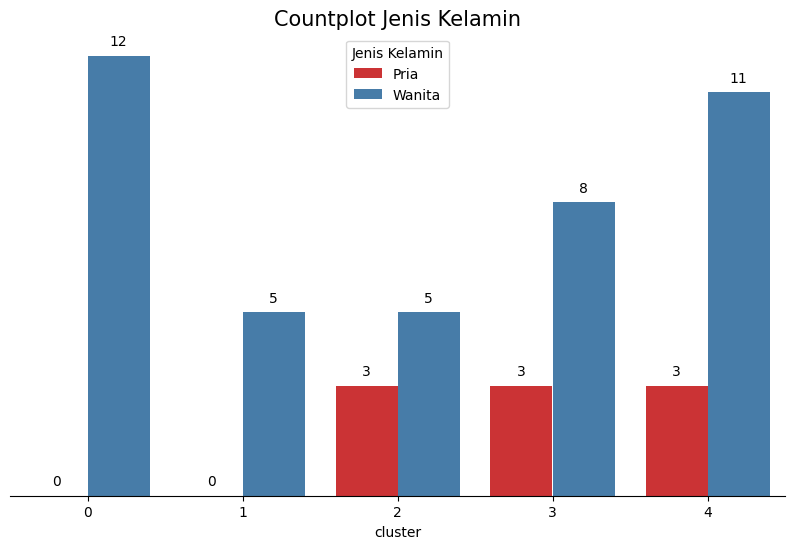

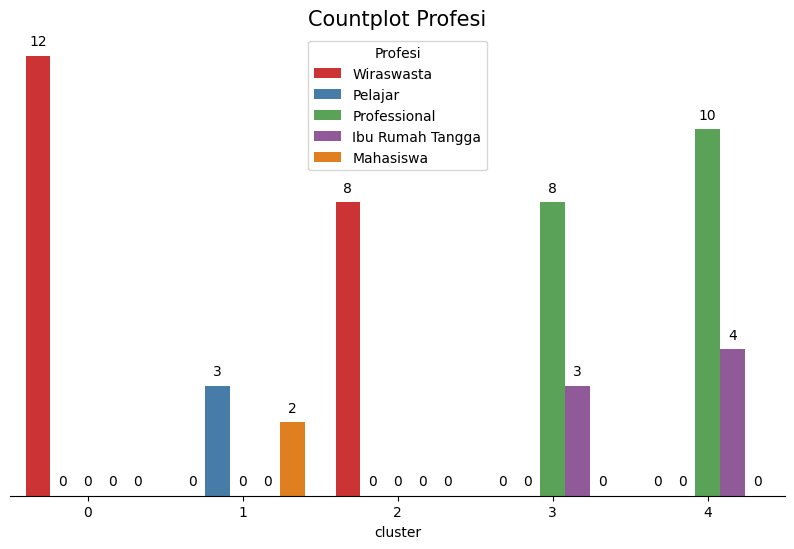

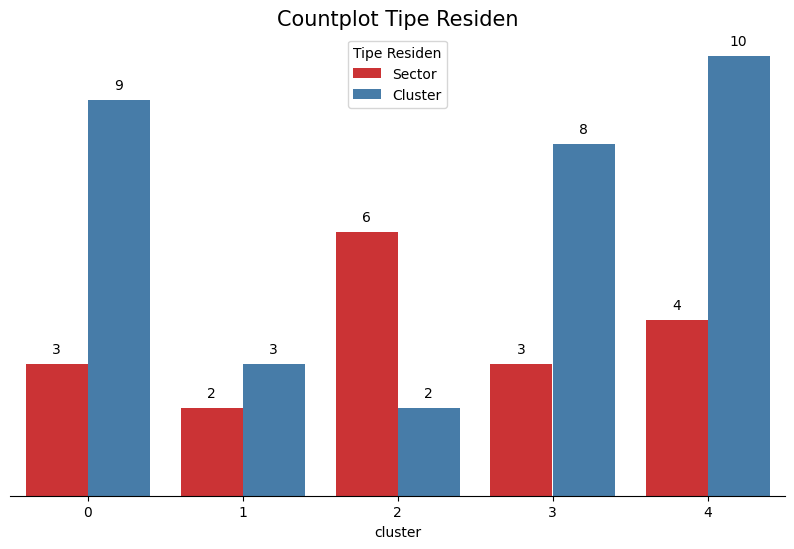

In [16]:
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=df_final, x="cluster", hue=col, palette="Set1")
    plt.title("Countplot %s"%col, fontsize=15)

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), ".0f"),
            xy = (p.get_x() + p.get_width()/2, p.get_height()),
            ha = "center",
            va = "center",
            xytext = (0, 10),
            textcoords = "offset points"
        )
    
    sns.despine(right=True, top=True, left=True)
    ax.axes.yaxis.set_visible(False)
    plt.show()

### Menamakan Cluster

In [17]:
# Mapping Nama Kolom
df_final["Segmen"] = df_final["cluster"].map({
    0: "Adult Diamond Member",
    1: "Young Silver Member",
    2: "Old Diamond Member",
    3: "Old Gold Member",
    4: "Adult Gold Member"
})

display(df_final.head(5))
display(df_final.info())

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster,Segmen
0,CUST-001,Budi Anggara,Pria,58,Wiraswasta,Sector,9497927,2,Old Diamond Member
1,CUST-002,Shirley Ratuwati,Wanita,14,Pelajar,Cluster,2722700,1,Young Silver Member
2,CUST-003,Agus Cahyono,Pria,48,Professional,Cluster,5286429,3,Old Gold Member
3,CUST-004,Antonius Winarta,Pria,53,Professional,Cluster,5204498,3,Old Gold Member
4,CUST-005,"Ibu Sri Wahyuni, IR",Wanita,41,Wiraswasta,Cluster,10615206,0,Adult Diamond Member


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Customer_ID          50 non-null     object
 1   Nama Pelanggan       50 non-null     object
 2   Jenis Kelamin        50 non-null     object
 3   Umur                 50 non-null     int64 
 4   Profesi              50 non-null     object
 5   Tipe Residen         50 non-null     object
 6   NilaiBelanjaSetahun  50 non-null     int64 
 7   cluster              50 non-null     uint16
 8   Segmen               50 non-null     object
dtypes: int64(2), object(6), uint16(1)
memory usage: 3.4+ KB


None

### Kesimpulan

In [18]:
resume_segmentation_user = df_final.groupby(["cluster","Segmen","Profesi"]).agg({"Umur":"mean", "NilaiBelanjaSetahun":"mean"})
display(resume_segmentation_user)

Umur  NilaiBelanjaSetahun
cluster Segmen               Profesi                                         
0       Adult Diamond Member Wiraswasta        29.500000         9.995179e+06
1       Young Silver Member  Mahasiswa         19.000000         3.045350e+06
                             Pelajar           14.666667         2.827133e+06
2       Old Diamond Member   Wiraswasta        54.875000         1.003004e+07
3       Old Gold Member      Ibu Rumah Tangga  54.666667         5.497463e+06
                             Professional      51.875000         5.435396e+06
4       Adult Gold Member    Ibu Rumah Tangga  32.250000         6.030751e+06
                             Professional      29.200000         5.464061e+06

Kesimpulan

1. Cluster - 0 : Adult Diamond Member => Member dengan profesi Wiraswasta dengan rata - rata umur 29.5 Tahun dan rata - rata nilai belanja setahun 10 Jt-an
2. Cluster - 1 : Young Silver Member => Member dengan profesi Mahasiswa dengan rata - rata umur 19 tahun dengan rata - rata nilai belanja 3 jt-an dan Pelajar dengan rata - rata umur 15 tahun dengan nilai belanja setahun 1.8 jt
3. Cluster - 2 : Old Diamond Member => Member dengan profesi Wiraswasta dengan rata - rata umur 55 tahun dengan rata - rata nilai belanja 10 jt-an
4. Cluster - 3 : Old Gold Member => Member dengan profesi Ibu Rumah Tangga dengan rata - rata umur 55 tahun dengan rata - rata nilai belanja 5.5 jt-an dan profesi Professional dengan rata - rata umur 52 tahun dengan rata - rata nilai belanja 5.5 jt-an
5. Cluster - 4 : Adult Gold Member => Member dengan profesi Ibu Rumah Tangga dengan rata - rata umur 32 tahun dengan rata - rata nilai belanja 6 jt-an dan profesi Professional dengan rata - rata umur 29 tahun dan rata - rata nilai belanja 5.5 jt-an

Berdasarkan 5 Tipe Cluster maka cluster terbaik adalah cluster - 0 => Adult Diamond Member

## Mempersiapkan Data Baru

In [19]:
# Data Baru
print(df_final.columns.to_list())
data = [{
    "Customer_ID" : "CUST-100",
    "Nama Pelanggan" : "Usep Syaikal Arifin",
    "Jenis Kelamin" : "Pria",
    "Umur" : 45,
    "Profesi" : "Wiraswasta",
    "Tipe Residen" : "Cluster",
    "NilaiBelanjaSetahun" : 8230000
}]

# Membuat Dataframe
new_df = pd.DataFrame(data=data)

# Melihat Data
display(new_df)

['Customer_ID', 'Nama Pelanggan', 'Jenis Kelamin', 'Umur', 'Profesi', 'Tipe Residen', 'NilaiBelanjaSetahun', 'cluster', 'Segmen']


,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun
0,CUST-100,Usep Syaikal Arifin,Pria,45,Wiraswasta,Cluster,8230000


### Membuat Fungsi Data Pemrosesan

In [20]:
def data_preprocess(data):
    # Konversi Categorical Data
    categorical_columns = data.select_dtypes(exclude=["number"]).columns.to_list()
    categorical_columns = [element for element in categorical_columns if element not in ['Customer_ID', 'Nama Pelanggan']]
    data_encode = data[categorical_columns].copy()

    # Jenis Kelamin
    data_encode["Jenis Kelamin"] = data_encode["Jenis Kelamin"].map({
        "Pria":0,
        "Wanita":0,
    })

    # Profesi
    data_encode["Profesi"] = data_encode["Profesi"].map({
        "Ibu Rumah Tangga":0,
        "Mahasiswa":1,
        "Pelajar":2,
        "Professional":3,
        "Wiraswasta":4
    })

    # Tipe Residen
    data_encode["Tipe Residen"] = data_encode["Tipe Residen"].map({
        "Cluster":0,
        "Sector":1,
    })

    # Standarisasi Numerical Data
    numerical_columns = data.select_dtypes(include=["number"]).columns.to_list()
    data_std = data[numerical_columns].copy()

    # Standarisasi Kolom Umur
    data_std["Umur"] = (data_std["Umur"] - 37.5)/14.7

    # Standarisasi Kolom NilaiBelanjaSetahun
    data_std["NilaiBelanjaSetahun"] = (data_std["NilaiBelanjaSetahun"] - 706987.8)/2590619

    # Menggabungkan Categorical dan Numerical Data
    data_model = data_encode.merge(data_std, left_index=True, right_index=True, how="left")

    return data_model

# Menjalankan Fungsi
new_df_model = data_preprocess(new_df)
print(new_df_model)

   Jenis Kelamin  Profesi  Tipe Residen      Umur  NilaiBelanjaSetahun
0              0        4             0  0.510204             2.903944


## Memanggil Model dan Melakukan Prediksi

In [21]:
def modelling(data):
    # Memanggil Model
    model_kproto = pickle.load(open("model_kproto.pkl", "rb"))
    # Melakukan Prediksi
    cluster = model_kproto.predict(data, categorical=[0, 1, 2])
    return cluster

# Menjalankan Fungsi
cluster = modelling(new_df_model)
print(cluster)

[2]


## Menamakan Segmen

In [22]:
def menamakan_segmen(data, cluster):
    # Menggabungkan cluster dan data
    data_final = data.copy()
    data_final["cluster"] = cluster

    # Menamakan Segmen
    data_final["Segmen"] = data_final["cluster"].map({
        0: "Adult Diamond Member",
        1: "Young Silver Member",
        2: "Old Diamond Member",
        3: "Old Gold Member",
        4: "Adult Gold Member"
    })

    return data_final

# Menjalankan Fungsi 
new_data = menamakan_segmen(new_df, cluster)
display(new_data)

,Customer_ID,Nama Pelanggan,Jenis Kelamin,Umur,Profesi,Tipe Residen,NilaiBelanjaSetahun,cluster,Segmen
0,CUST-100,Usep Syaikal Arifin,Pria,45,Wiraswasta,Cluster,8230000,2,Old Diamond Member
